In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

In [2]:
model_id = 'ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_32_firstc_10_phi_beta_cosine_betamax_0.5_betamin_0.001'
input_dir ='/mnt/home/dheurtel/ceph/04_inference/sbc/'+model_id

In [3]:
sbc_files = [f for f in os.listdir(input_dir) if 'MN' in f]
sbc_files.sort()
print(sbc_files)

noise_levels = np.unique(np.array([float(f.split("_")[3]) for f in sbc_files]))
print("Noise levels:", noise_levels)

['sbc_MN_sims_0.1_0.pt', 'sbc_MN_sims_0.1_1.pt', 'sbc_MN_sims_0.1_2.pt', 'sbc_MN_sims_0.1_3.pt', 'sbc_MN_sims_0.2_0.pt', 'sbc_MN_sims_0.2_1.pt', 'sbc_MN_sims_0.2_2.pt', 'sbc_MN_sims_0.2_3.pt', 'sbc_MN_sims_0.3_0.pt', 'sbc_MN_sims_0.3_1.pt', 'sbc_MN_sims_0.3_2.pt', 'sbc_MN_sims_0.3_3.pt', 'sbc_MN_sims_0.5_0.pt', 'sbc_MN_sims_0.5_1.pt', 'sbc_MN_sims_0.5_2.pt', 'sbc_MN_sims_0.5_3.pt']
Noise levels: [0.1 0.2 0.3 0.5]


In [4]:
# Load files
phi_truth_all = {}
phi_samples_all = {}
max_num_samples = 400
for noise_level in noise_levels:
    print("Noise level:", noise_level)
    phi_truth_all[noise_level] = None
    phi_samples_all[noise_level] = None
    for sbc_file in [f for f in sbc_files if f.find(str(noise_level)) != -1]:
        print(sbc_file)
        sbc_file = os.path.join(input_dir, sbc_file)
        sbc_data = torch.load(sbc_file)
        phi_truth = sbc_data["rphi_true"].detach().cpu()
        phi_samples = sbc_data["tensor_rphi_list"].detach().cpu()
        if phi_truth_all[noise_level] is None:
            if phi_samples.shape[0] < max_num_samples:
                continue
            phi_truth_all[noise_level] = phi_truth
            phi_samples_all[noise_level] = phi_samples[:max_num_samples, :, :]
        else:
            if phi_samples.shape[0] < max_num_samples:
                continue
            phi_truth_all[noise_level] = torch.cat((phi_truth_all[noise_level], phi_truth), dim=0)
            phi_samples_all[noise_level] = torch.cat((phi_samples_all[noise_level], phi_samples[:max_num_samples, :, :]), dim=1)
    try:
        print(phi_truth_all[noise_level].shape, phi_samples_all[noise_level][:max_num_samples, :, :].shape)
    except:
        print("No samples for noise level", noise_level)

Noise level: 0.1
sbc_MN_sims_0.1_0.pt


sbc_MN_sims_0.1_1.pt
sbc_MN_sims_0.1_2.pt
sbc_MN_sims_0.1_3.pt
torch.Size([768, 2]) torch.Size([400, 768, 2])
Noise level: 0.2
sbc_MN_sims_0.2_0.pt
sbc_MN_sims_0.2_1.pt
sbc_MN_sims_0.2_2.pt
sbc_MN_sims_0.2_3.pt
torch.Size([1024, 2]) torch.Size([400, 1024, 2])
Noise level: 0.3
sbc_MN_sims_0.3_0.pt
sbc_MN_sims_0.3_1.pt
sbc_MN_sims_0.3_2.pt
sbc_MN_sims_0.3_3.pt
torch.Size([1024, 2]) torch.Size([400, 1024, 2])
Noise level: 0.5
sbc_MN_sims_0.5_0.pt
sbc_MN_sims_0.5_1.pt
sbc_MN_sims_0.5_2.pt
sbc_MN_sims_0.5_3.pt
torch.Size([1024, 2]) torch.Size([400, 1024, 2])


In [5]:
nb_burning_samples = 1

# Get rid of the burnin samples
for noise_level in noise_levels:
    phi_samples_all[noise_level] = phi_samples_all[noise_level][nb_burning_samples:, :, :]

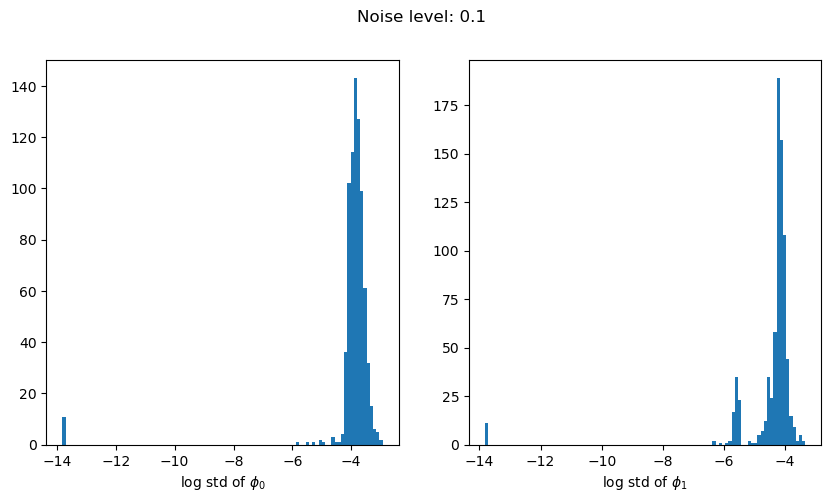

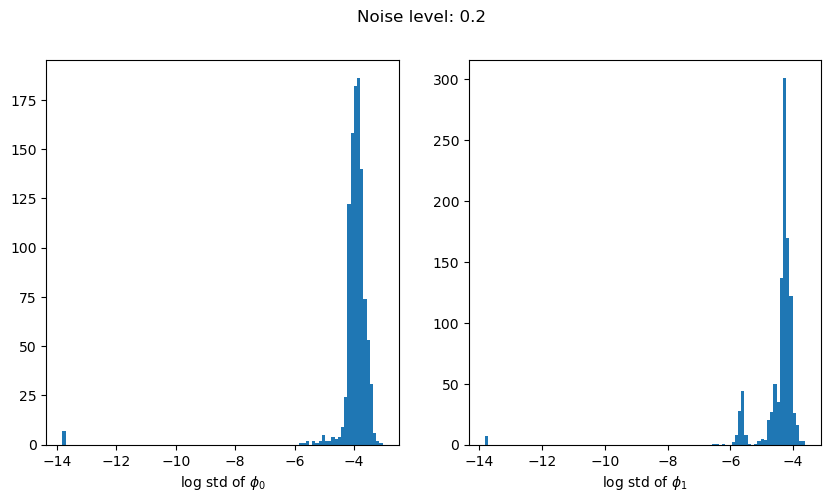

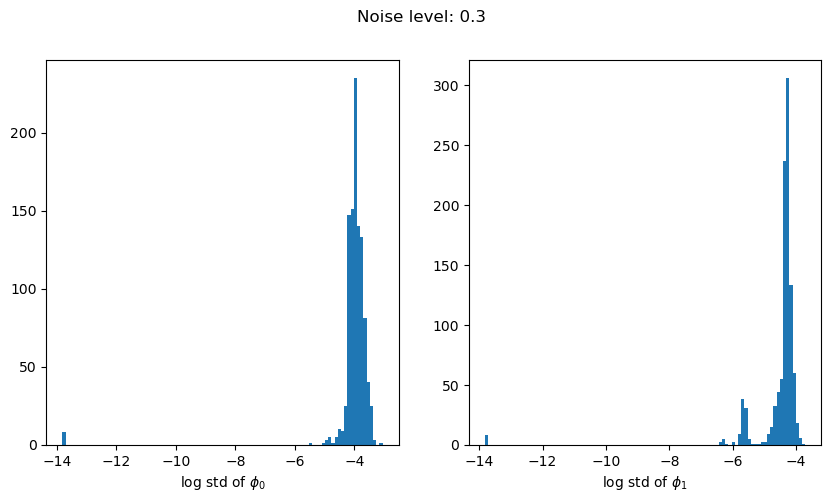

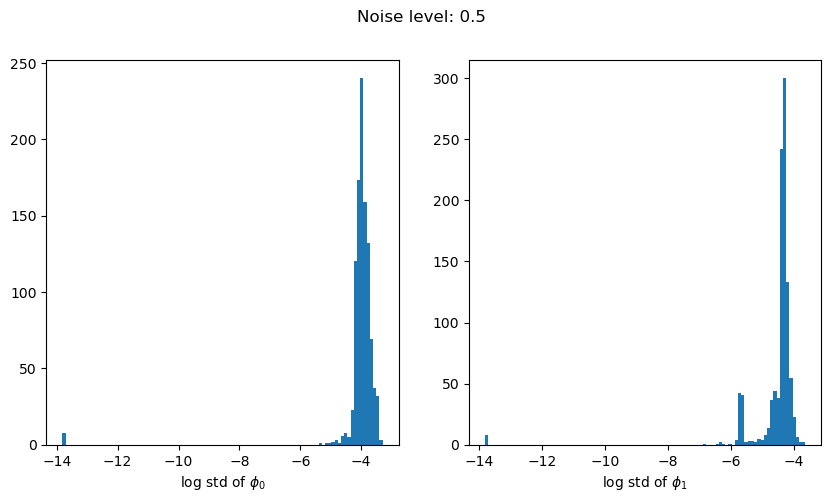

In [6]:
# Show histogram of stds
eps = 1e-6
for noise_level in noise_levels:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].hist(torch.log(phi_samples_all[noise_level][..., 0].std(dim=0) + eps), bins=100)
    axs[0].set_xlabel("log std of $\phi_0$")
    axs[1].hist(torch.log(phi_samples_all[noise_level][..., 1].std(dim=0) + eps), bins=100)
    axs[1].set_xlabel("log std of $\phi_1$")
    plt.suptitle("Noise level: " + str(noise_level))
    plt.show()

In [7]:
# Remove chains that have not converged
# Add a condition about distance to the true value (if mean dist larger than 0.5, then remove)

threshold = -7
converged_indices = {}
not_converged_indices = {}
for noise_level in noise_levels:
    print("Noise level:", noise_level)
    converged_indices[noise_level] = torch.where(torch.logical_and(torch.log(phi_samples_all[noise_level][..., 0].std(dim=0) + eps) >= threshold,torch.logical_and(
                                                    torch.log(phi_samples_all[noise_level][..., 1].std(dim=0) + eps) >= threshold, 
                                                    torch.norm(phi_samples_all[noise_level].mean(dim=0) - phi_truth_all[noise_level], dim=1) <=0.5,)))[0]
    not_converged_indices[noise_level] = torch.where(torch.logical_or(torch.logical_or(torch.log(phi_samples_all[noise_level][..., 0].std(dim=0) + eps) < threshold,
                                                        torch.log(phi_samples_all[noise_level][..., 1].std(dim=0) + eps) < threshold), 
                                                        torch.norm(phi_samples_all[noise_level].mean(dim=0) - phi_truth_all[noise_level], dim=1) > 0.5))[0]
    print("Number of chains that have not converged:", not_converged_indices[noise_level].shape[0])

Noise level: 0.1
Number of chains that have not converged: 11
Noise level: 0.2
Number of chains that have not converged: 7
Noise level: 0.3
Number of chains that have not converged: 8
Noise level: 0.5
Number of chains that have not converged: 8


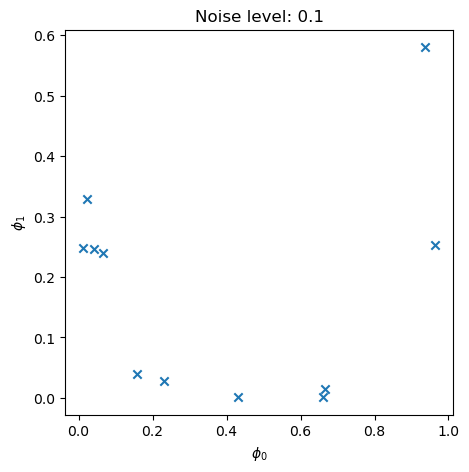

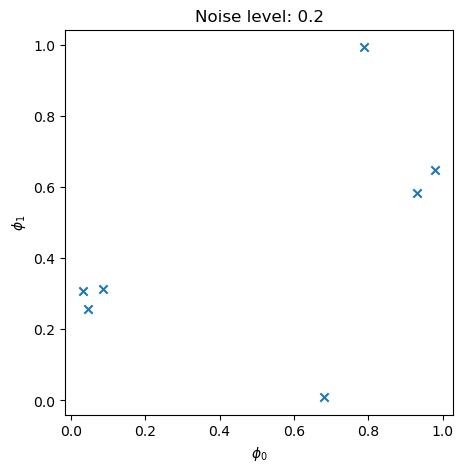

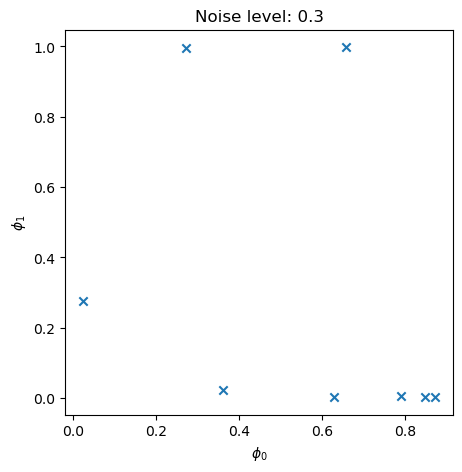

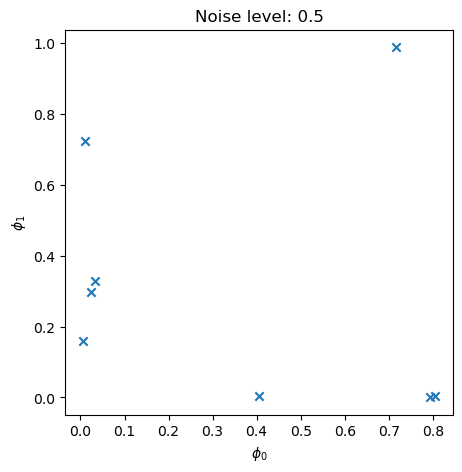

In [8]:
# Plot parameters for the chains that have not converged
for noise_level in noise_levels:
    plt.figure(figsize=(5, 5))
    plt.scatter(phi_truth_all[noise_level][not_converged_indices[noise_level], 0],
                phi_truth_all[noise_level][not_converged_indices[noise_level], 1],
                marker='x')
    plt.xlabel("$\phi_0$")
    plt.ylabel("$\phi_1$")
    plt.title("Noise level: " + str(noise_level))
    plt.show()

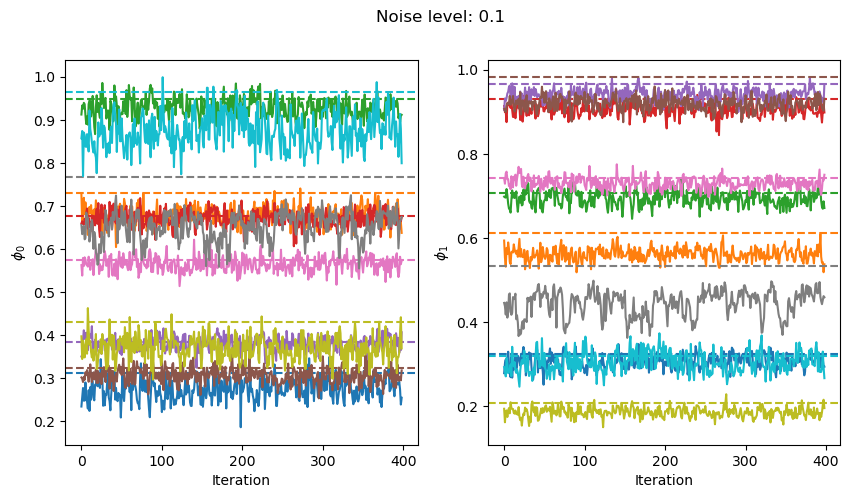

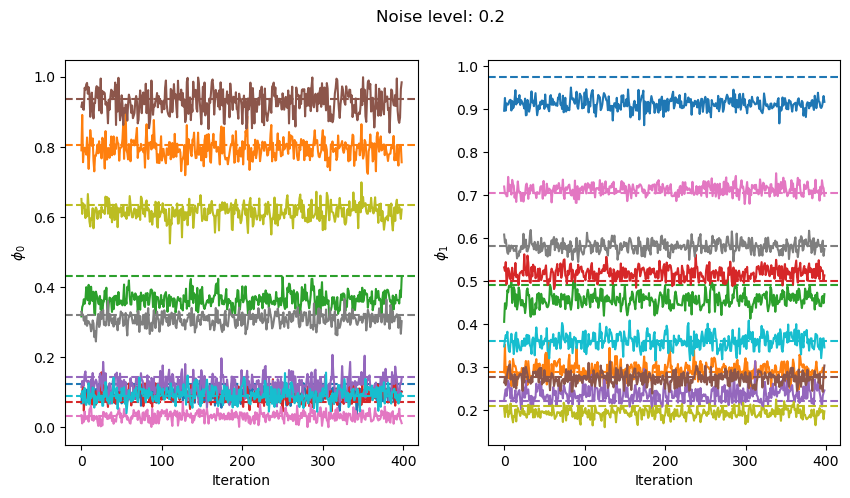

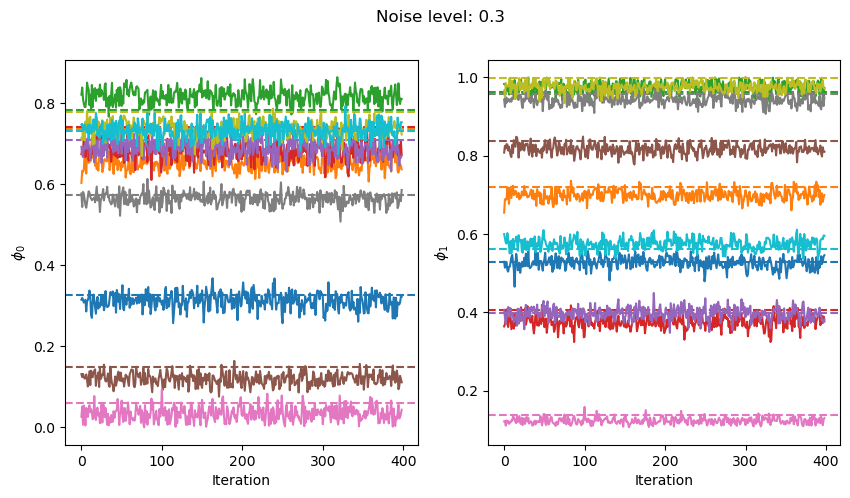

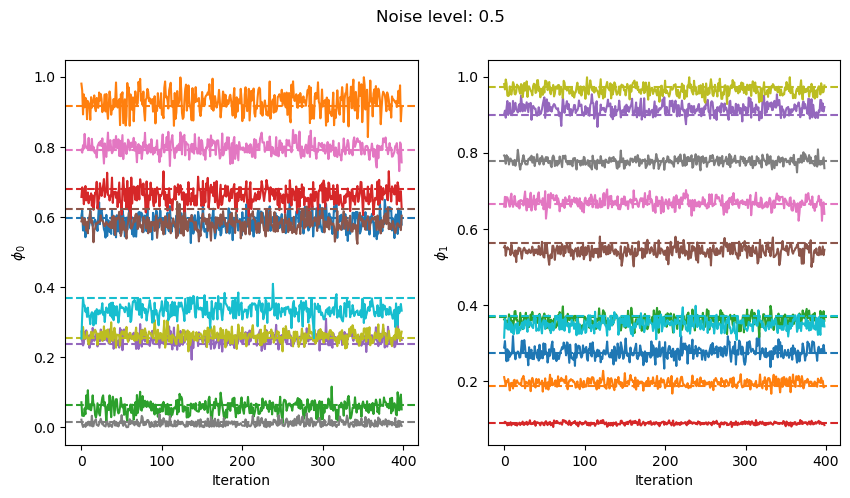

In [9]:
# Plot randomly selected chains
nb_plot_chains = 10

for noise_level in noise_levels:

    plot_indices = torch.randperm(phi_samples_all[noise_level][:,converged_indices[noise_level]].shape[1])[:nb_plot_chains]
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    for i in range(nb_plot_chains):
        axs[0].plot(phi_samples_all[noise_level][:,converged_indices[noise_level]][:, plot_indices[i], 0], color=f'C{i}')
        axs[0].axhline(phi_truth_all[noise_level][converged_indices[noise_level]][plot_indices[i], 0], color=f'C{i}', linestyle='--')
        axs[1].plot(phi_samples_all[noise_level][:,converged_indices[noise_level]][:, plot_indices[i], 1], color=f'C{i}')
        axs[1].axhline(phi_truth_all[noise_level][converged_indices[noise_level]][plot_indices[i], 1], color=f'C{i}', linestyle='--')
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("$\phi_0$")
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("$\phi_1$")
    plt.suptitle("Noise level: " + str(noise_level))
    plt.show()

In [10]:
# Compute rank statistics
ranks = {}
for noise_level in noise_levels:
    phi_truth_all_converged = phi_truth_all[noise_level][converged_indices[noise_level], :]
    phi_samples_all_converged = phi_samples_all[noise_level][:, converged_indices[noise_level], :]
    ranks[noise_level] = torch.zeros(phi_truth_all_converged.shape[0], phi_truth_all_converged.shape[1])
    autocorrelation_length = torch.zeros(phi_truth_all_converged.shape[0], phi_truth_all_converged.shape[1])
    for i in range(phi_truth_all_converged.shape[0]):
        az_infdata = az.convert_to_inference_data(phi_samples_all_converged[:, i][None, :].numpy())
        for j in range(phi_truth_all_converged.shape[1]):
            autocorrelation_length[i, j] = len(phi_samples_all_converged[:, i, j]) / az.ess(az_infdata)['x'].values[j]
            ranks[noise_level][i, j] = torch.mean((phi_samples_all_converged[::max(int(autocorrelation_length[i, j]), 1), i, j] < phi_truth_all_converged[i, j]).float())

/mnt/sw/nix/store/pvz51gzx2lyqpabf08xhd1y2kvw5rfdy-python-3.9.16-view/lib/python3.9/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


In [11]:
from scipy.stats import binom

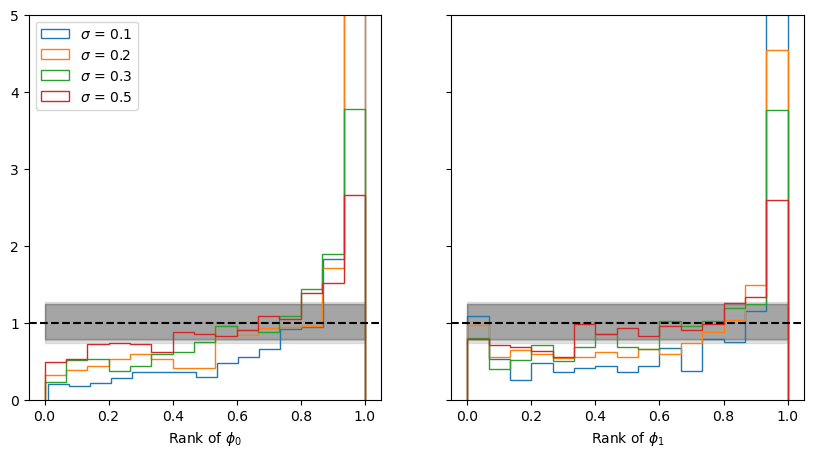

In [12]:
# Plot ranks statistics
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
for noise_level in noise_levels:
    nbins = 15
    axs[0].hist(ranks[noise_level][:, 0], bins=nbins, density=True, histtype='step', label=f"$\sigma$ = {noise_level}")
    axs[1].hist(ranks[noise_level][:, 1], bins=nbins, density=True, histtype='step')
    N = ranks[noise_level].shape[0]
    q0 = binom.ppf(0.025, N, 1.0/nbins) * nbins/N
    q1 = binom.ppf(0.975, N, 1.0/nbins) * nbins/N
    axs[0].fill_between([0, 1], q0, q1, color='black', alpha=0.1) # 95% confidence interval (following Talts et al. 2018)
    axs[1].fill_between([0, 1], q0, q1, color='black', alpha=0.1) # 95% confidence interval (following Talts et al. 2018)
axs[0].axhline(1.0, color='black', linestyle='--')
axs[0].set_xlabel("Rank of $\phi_0$")
axs[1].axhline(1.0, color='black', linestyle='--')
axs[1].set_xlabel("Rank of $\phi_1$")
axs[0].legend()
axs[0].set_ylim([0, 5])
plt.savefig("ranks.pdf")
plt.show()

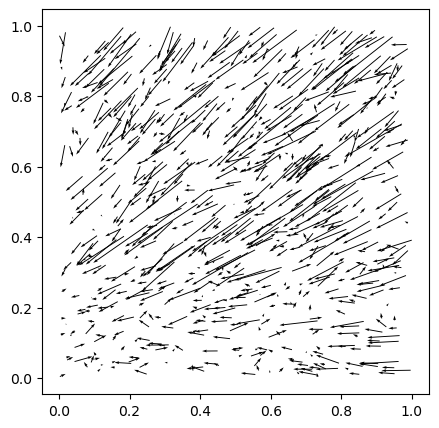

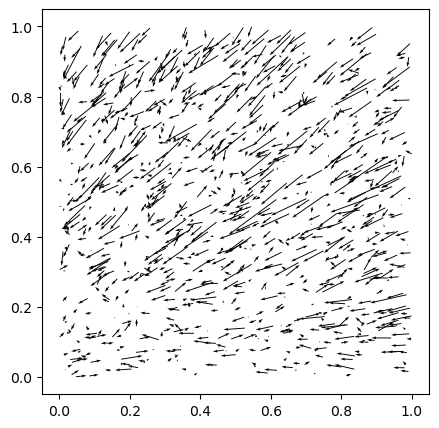

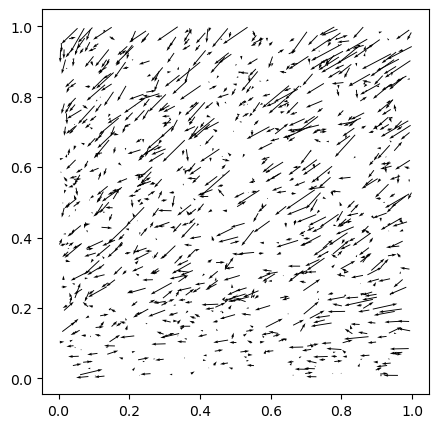

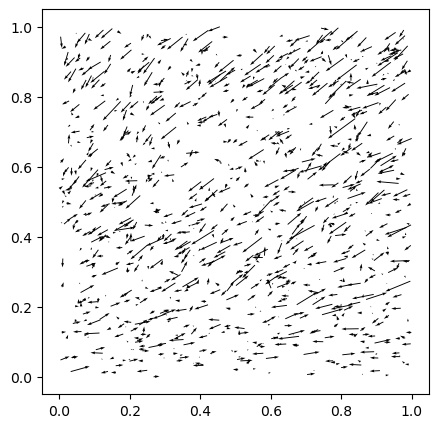

In [13]:
for noise_level in noise_levels:
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    phi_truth_all_converged = phi_truth_all[noise_level][converged_indices[noise_level], :]
    phi_samples_all_converged = phi_samples_all[noise_level][:, converged_indices[noise_level], :]
    ## Plot a vector field where each vector starts at the true value and ends at the mean of the chains
    axs.quiver(phi_truth_all_converged[:, 0], phi_truth_all_converged[:, 1], 
            phi_samples_all_converged.mean(dim=0)[:, 0] - phi_truth_all_converged[:, 0], 
            phi_samples_all_converged.mean(dim=0)[:, 1] - phi_truth_all_converged[:, 1], 
            scale=1, scale_units='xy', angles='xy')


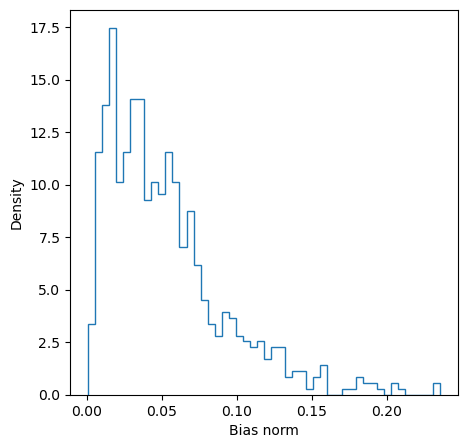

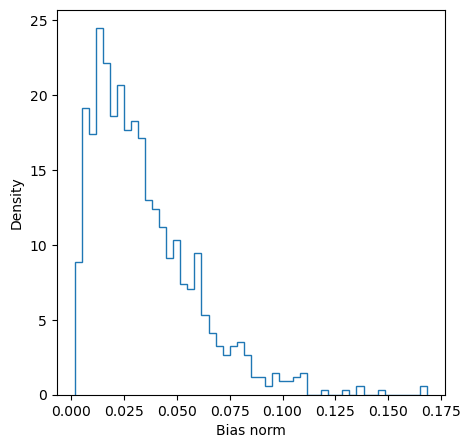

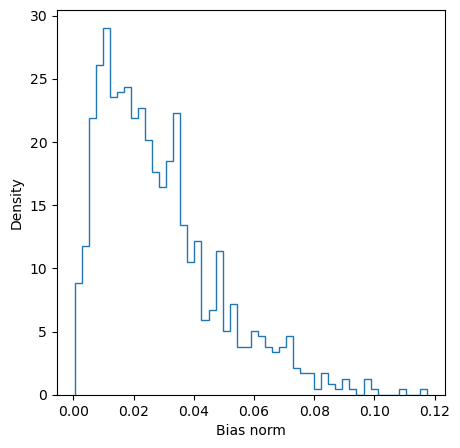

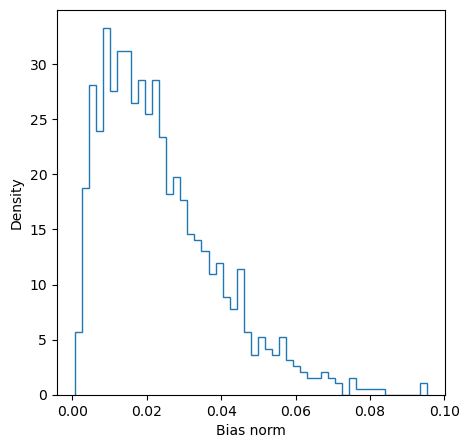

In [14]:
for noise_level in noise_levels:
    ## Plot the distribution for the bias norm 
    phi_truth_all_converged = phi_truth_all[noise_level][converged_indices[noise_level], :]
    phi_samples_all_converged = phi_samples_all[noise_level][:, converged_indices[noise_level], :]
    # Compute the bias norm
    bias_norm = torch.norm(phi_samples_all_converged.mean(dim=0) - phi_truth_all_converged, dim=1)

    # Plot the distribution
    plt.figure(figsize=(5, 5))
    plt.hist(bias_norm, bins=50, histtype='step', density=True)
    plt.xlabel("Bias norm")
    plt.ylabel("Density")
    plt.show()